# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import plotly.express as px
import datetime
import seaborn as sns; sns.set()

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = "\t")
except:
    data = pd.read_csv('C:/Users/Victoria/anaconda/envs/ds_practicum_env/real_estate_data.csv' , sep = "\t")

In [3]:
#Изучим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В данных много нулевых значений, а также некорректный тип данных. Постараемся устранить пропуски там, где это возможно.

In [4]:
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


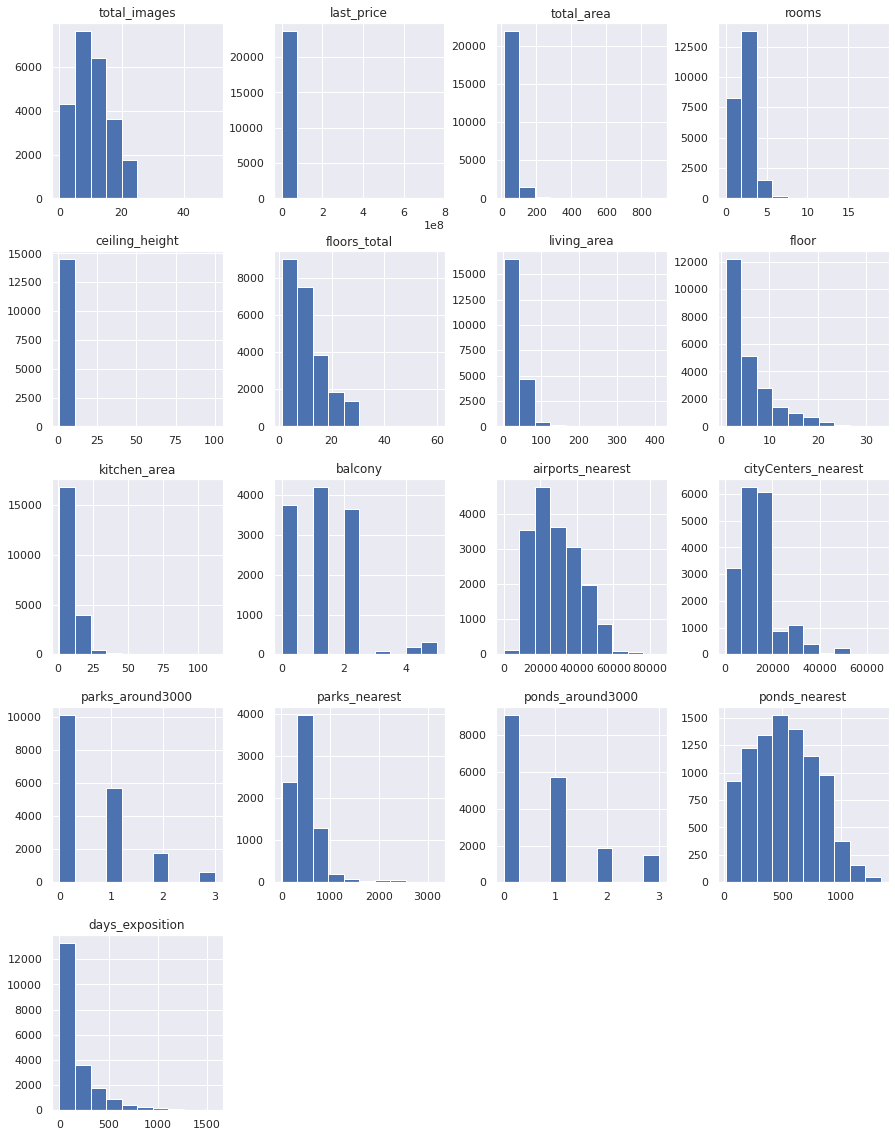

In [5]:
# Построим общую гистограмму для всех столбцов таблицы

data.hist(figsize = (15,20));

In [6]:
# Посмотрим в каких стобцах есть пропуски
data.isna().sum()
round(data.isna().sum()/len(data)*100)

total_images             0.0
last_price               0.0
total_area               0.0
first_day_exposition     0.0
rooms                    0.0
ceiling_height          39.0
floors_total             0.0
living_area              8.0
floor                    0.0
is_apartment            88.0
studio                   0.0
open_plan                0.0
kitchen_area            10.0
balcony                 49.0
locality_name            0.0
airports_nearest        23.0
cityCenters_nearest     23.0
parks_around3000        23.0
parks_nearest           66.0
ponds_around3000        23.0
ponds_nearest           62.0
days_exposition         13.0
dtype: float64

**Проблемы в данных**

<b>Пропуски</b>

- is_apartment - **88%** (возможно столбец в датафрейме появился позже, логично заменить пропуски на False, т.к если не указали что это апартаменты, то скорее всего они ими не являются)
- parks_nearest - **66%** и ponds_nearest - **62%** (пропуски в столбцах с картографическими данными, заполнять не нужно, кроме тех случаев, когда мы знаем, что водоемов или парков в близи нет). 
- balcony **49%** (заменим пропуски на 0 т.к скорее всего если продавец не указал о наличии балкона, то его нет)
- ceiling_height - **39%** (скорее всего пропуски возникли случайно, можно заменить пропуски на медианные значения, так как основная часть данных в этом столбце находится в небольшом диапазоне.)          
- parks_around3000 **23%** и ponds_around3000 **23%** (заполним пропуски на 0, т.к скорее всего, если продавец не указал данные о наличии парков и водоемов, то их нет)
- cityCenters_nearest **23%** и airports_nearest **23%** (пропуски в столбцах с картографическими данными, заполнять не нужно)
- days_exposition - **13%** (раз кол-во дней не указано, то вероятнее всего, квартира еще не продана - эти пропуски заполнять не нужно)
- kitchen_area **10%** (нужно проверить не студия ли это, для студий заменить пропуски на 0)
-living_area 8% 

<b>Типы данных, которые нужно заменить:</b>
- first_day_exposition  тип **object** - нужно заменить на формат даты date, чтобы работать дальше с этими значениями было возможно
- is_apartment тип **object** - нужно заменить на bool, т.к данные в столбце (False и True) - логические значенич 
- balcony тип **float64** - нужно заменить на int, т.к кол-во балконов это целочисленное значение
- parks_around3000 тип **float64** - нужно заменить на int, т.к кол-во парков это целочисленное значение
- ponds_around3000 тип **float64** - нужно заменить на int, т.к кол-во водоемов это целочисленное значение

<b>Дубликаты</b>

Необходимо проверить данные на наличие явных и неявных дубликатов: при предпросмотре датафрейма в столбце locality_name можно заменить наличие буквы ё - частой причины возникновения неявных дубликатов.

<b>Странные значения</b>

Необходимо проверить данные на наличие странных значений и выбросов - лучше всего это сделать используя визуализацию

### Предобработка данных

In [7]:
#Поиск явных дубликатов
data.duplicated().sum()

0

Явных дубликатов не обнаружено

In [8]:
#Замена пропусков и изменение типов данных

data['balcony'] = data['balcony'].fillna(0) #Заполняем пропуски на значение "0", так как раз продавец не указал количетсво балконов, то их, скорее всего нет.
data['balcony'] = data['balcony'].astype('int') #Меняем тип данных на int, поскольку кол-во балконов это целочисленные значения

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].mean()) #Заполняем пропуски на медианные значения, так как данные о продаже квартир в одном регионе (Санкт-Петербург и окрестности) и медиана лучше всего опишет этот параметр.

data['is_apartment'] = data['is_apartment'].fillna(False) #Заполняем пропуски на значение False, так как если продавец зне указал является ли жилье апартаментами, то скорее всего не является.
data['is_apartment'] = data['is_apartment'].astype('bool') #Меняем тип данных на bool, поскольку это логическое значение

data['ponds_around3000'] = data['ponds_around3000'].fillna(0) #Заполняем пропуски на значение "0", так как раз продавец не указал количетсво водоемов в радиусе 3 км, то их, скорее всего нет.
data['ponds_nearest'] = data.query('ponds_around3000 == 0')['ponds_nearest'].fillna(0) #Заполняем пропуски на значение "0" для тех квартир, в радиусе 3 км от которых нет водоемов, поскольку выше 3 км только одно значение в выборке

data['parks_around3000'] = data['parks_around3000'].fillna(0) #Заполняем пропуски на значение "0", так как раз продавец не указал количетсво парков в радиусе 3 км, то их, скорее всего нет.
data['parks_nearest'] = data.query('parks_around3000 == 0')['parks_nearest'].fillna(0) #Заполняем пропуски на значение "0" для тех квартир, в радиусе 3 км от которых нет парков.

data['kitchen_area'] = data.query('studio == 0')['kitchen_area'].fillna(0) #Заполняем пропуски на значение "0" для тех квартир, которые являются студиями.

data['living_area'] = data['living_area'].fillna(data['total_area']*data['living_area'].median()/data['total_area'].median()) #Заполняем пропуски на долю жилой площади выборки, рассчитанной по медианным значениям, общей и жилой площадей.

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d') #Меняем формат даты на формат без времени, т.к время не указано.

data['ceiling_height'] = data['ceiling_height'].round(2) #Округляем значения до 2 знаков после запятой для удобства просмотра

In [9]:
#Поиск неявных дубликатов

print(data['locality_name'].nunique())


364


In [10]:
#Устраняем неявные дубликаты
data['locality_name'] = data['locality_name'].str.replace('посёлок ','поселок ')
data['locality_name'] = data['locality_name'].str.replace('деревня ',' ')
data['locality_name'] = data['locality_name'].str.replace('село ',' ')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ',' ')
data['locality_name'] = data['locality_name'].str.replace('городского типа ','')
data['locality_name'] = data['locality_name'].str.replace('городской ','')


In [11]:
print(data['locality_name'].nunique()) 

322


Убрали значительное количество неявных дубликатов в названии населенного пункта.

In [12]:
#Поиск редких и выбивающихся значений

data.loc[data['ceiling_height'] >= 20,'ceiling_height'] = data['ceiling_height']/10 #Устраняем ошибки в значениях высоты потолка, средняя высота потолков 2,7 м, т.е во всех значениях больше 20 вероятнее всего ошиблись в запятой 

data = data[data['ceiling_height'] < 3] #Устраняем выбросы - все записи, для которых высота потолков выше 3 метров.

In [13]:
data.describe() #Оцениваем выбросы в других значениях

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,21078.000000,2.107800e+04,21078.000000,21078.000000,21078.000000,20993.000000,21078.000000,21078.000000,20940.000000,21078.000000,15730.000000,15749.000000,21078.000000,14669.000000,21078.000000,13524.0,18478.000000
mean,9.765490,5.604654e+06,56.070672,1.972531,2.686131,11.148097,31.966451,6.110732,9.103607,0.612487,29174.499046,15114.401930,0.400939,0.643807,0.525999,0.0,172.715662
std,5.629521,8.799945e+06,28.996175,0.983594,0.115648,6.672076,18.099148,5.007522,5.636381,0.961092,13035.388273,8341.141009,0.685513,45.023867,0.824186,0.0,211.152938
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,318.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,6.000000,3.300000e+06,39.000000,1.000000,2.600000,5.000000,18.400000,2.000000,6.200000,0.000000,18041.000000,10893.000000,0.000000,0.000000,0.000000,0.0,44.000000
50%,9.000000,4.400000e+06,49.700000,2.000000,2.770000,9.000000,29.300000,5.000000,8.500000,0.000000,27738.500000,13723.000000,0.000000,0.000000,0.000000,0.0,91.000000
75%,14.000000,6.077500e+06,65.000000,3.000000,2.770000,16.000000,40.000000,8.000000,11.000000,1.000000,38171.000000,16722.000000,1.000000,0.000000,1.000000,0.0,217.000000
max,50.000000,7.630000e+08,900.000000,19.000000,2.990000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,0.0,1580.000000


Все прочие максимальные значения являются приемлемыми

In [14]:
data['last_price'] = data['last_price']/1000000 #Приводим значение цены к млн руб, для удобства просмотра

In [15]:
data.isna().sum() # в данных остались пропуски, которые мы не можем заполнить, на анализ данные пропуски не должны повлиять, поэтому можем их оставить

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total              85
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             138
balcony                    0
locality_name             42
airports_nearest        5348
cityCenters_nearest     5329
parks_around3000           0
parks_nearest           6409
ponds_around3000           0
ponds_nearest           7554
days_exposition         2600
dtype: int64

### Посчитайте и добавьте в таблицу новые столбцы

In [16]:
#Добавляем столбец с ценой квадратного метра
data['price_per_square_meter'] = (data['last_price']*1000000)/ data['total_area'] 
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int') #Присваеваем тим int для наглядности

#Добавляем столбец со днем недели публикации объявления
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday


#Добавляем столбец с месяцем публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

#Добавляем столбец с годом публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

#Добавляем тип этажа квартиры
data['floor_category'] = data.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total)  
    else 'другой'), axis=1
)

data['floor_category_digit'] = data.apply(
    lambda x: 0 if (x.floor == 1) 
    else (2 if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 1), axis=1
)

#Добавляем столбец со значением расстояние до центра города в километрах 
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)


In [17]:
data.head() #Проверяем, что все столбцы добавились

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,floor_category_digit,cityCenters_nearest_km
0,20,13.000,108.0,2019-03-07,3,2.70,16.0,51.000000,8,False,...,2.0,NaN,NaN,120370,3,3,2019,другой,1,16.0
1,7,3.350,40.4,2018-12-04,1,2.77,11.0,18.600000,1,False,...,0.0,0.0,81.0,82920,1,12,2018,первый,0,19.0
2,10,5.196,56.0,2015-08-20,2,2.77,5.0,34.300000,4,False,...,2.0,NaN,558.0,92785,3,8,2015,другой,1,14.0
3,0,64.900,159.0,2015-07-24,3,2.77,14.0,91.730769,9,False,...,3.0,NaN,424.0,408176,4,7,2015,другой,1,7.0
5,10,2.890,30.4,2018-09-10,1,2.77,12.0,14.400000,5,False,...,0.0,0.0,55.0,95065,0,9,2018,другой,1,NaN


### Проведите исследовательский анализ данных

In [18]:
#Изучаем параметры объекстов
display(data.describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,cityCenters_nearest_km
count,21078.000000,21078.000000,21078.000000,21078.000000,21078.000000,20993.000000,21078.000000,21078.000000,20940.000000,21078.000000,...,14669.000000,21078.000000,13524.0,18478.000000,2.107800e+04,21078.000000,21078.000000,21078.000000,21078.000000,15749.000000
mean,9.765490,5.604654,56.070672,1.972531,2.686131,11.148097,31.966451,6.110732,9.103607,0.612487,...,0.643807,0.525999,0.0,172.715662,9.494703e+04,2.585777,6.410618,2017.373755,0.877360,15.109150
std,5.629521,8.799945,28.996175,0.983594,0.115648,6.672076,18.099148,5.007522,5.636381,0.961092,...,45.023867,0.824186,0.0,211.152938,4.047831e+04,1.794627,3.488254,1.027532,0.328031,8.347222
min,0.000000,0.012190,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.000000,1.110000e+02,0.000000,1.000000,2014.000000,0.000000,0.000000
25%,6.000000,3.300000,39.000000,1.000000,2.600000,5.000000,18.400000,2.000000,6.200000,0.000000,...,0.000000,0.000000,0.0,44.000000,7.486000e+04,1.000000,3.000000,2017.000000,1.000000,11.000000
50%,9.000000,4.400000,49.700000,2.000000,2.770000,9.000000,29.300000,5.000000,8.500000,0.000000,...,0.000000,0.000000,0.0,91.000000,9.318100e+04,3.000000,6.000000,2017.000000,1.000000,14.000000
75%,14.000000,6.077500,65.000000,3.000000,2.770000,16.000000,40.000000,8.000000,11.000000,1.000000,...,0.000000,1.000000,0.0,217.000000,1.109338e+05,4.000000,10.000000,2018.000000,1.000000,17.000000
max,50.000000,763.000000,900.000000,19.000000,2.990000,60.000000,409.700000,33.000000,112.000000,5.000000,...,3190.000000,3.000000,0.0,1580.000000,1.907500e+06,6.000000,12.000000,2019.000000,1.000000,66.000000


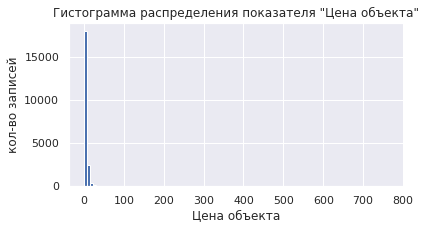

In [19]:
(
    data['last_price']
        .sort_values()
        .plot(y='last_price', kind='hist', 
              bins=100, range=(0,763), grid=True, title='Гистограмма распределения показателя "Цена объекта"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Цена объекта')
);

На гистограмме мы видим, кто кол-во записей для показателей цена объекта выше 100 млн очень мала. 
Построим еще одну диаграмму с областью построения до 100 млн.

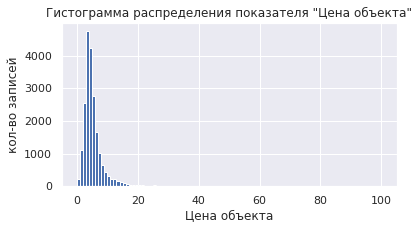

In [20]:
(
    data['last_price']
        .sort_values()
        .plot(y='last_price', kind='hist', 
              bins=100, range=(0,100), grid=True, title='Гистограмма распределения показателя "Цена объекта"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Цена объекта')
);

Распределение по прежнему имеет длинный "хвост", для того, чтобы привести выборку к нормальному распределению можем отбросить все значения выше 40 млн.

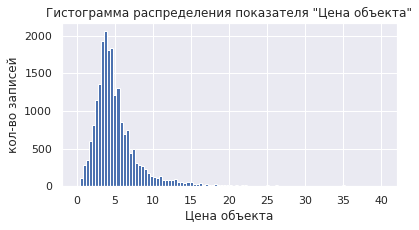

In [21]:
data=data[data['last_price']<40]
(
    data['last_price']
        .sort_values()
        .plot(y='last_price', kind='hist', 
              bins=100, range=(0,40), grid=True, title='Гистограмма распределения показателя "Цена объекта"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Цена объекта')
);

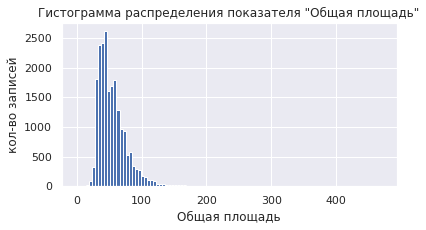

In [22]:
(
    data['total_area']
        .sort_values()
        .plot(y='total_area', kind='hist', 
              bins=100, range=(0,470), grid=True, title='Гистограмма распределения показателя "Общая площадь"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Общая площадь')
);

 На графике чётко видно, что после 200м квартир практически нет. В данном случае аномальными значениями можно считать все квартиры больше 200 м. Значит эти значения нужно отбросить.

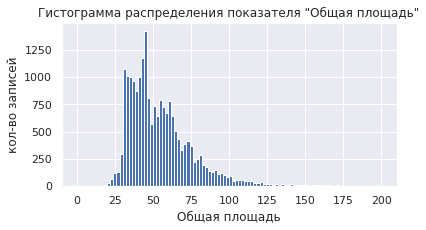

In [23]:
data=data[data['total_area']<200]
(
    data['total_area']
        .sort_values()
        .plot(y='total_area', kind='hist', 
              bins=100, range=(0,200), grid=True, title='Гистограмма распределения показателя "Общая площадь"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Общая площадь')
);

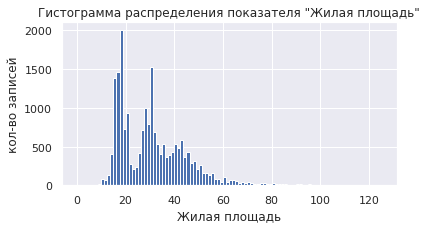

In [24]:
(
    data['living_area']
        .sort_values()
        .plot(y='living_area', kind='hist', 
              bins=100, range=(0,125), grid=True, title='Гистограмма распределения показателя "Жилая площадь"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Жилая площадь')
);

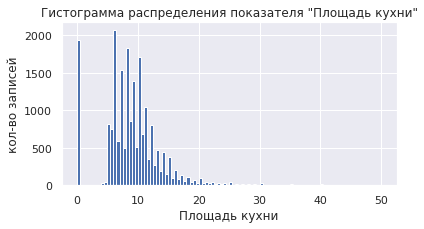

In [25]:
(
    data['kitchen_area']
        .sort_values()
        .plot(y='kitchen_area', kind='hist', 
              bins=100, range=(0,50), grid=True, title='Гистограмма распределения показателя "Площадь кухни"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Площадь кухни')
);

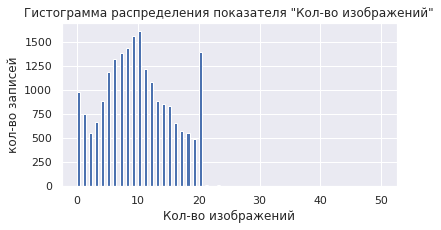

In [26]:
# Построим гистограмму для каждого столбца таблицы после подготовки данных
(
    data['total_images']
        .sort_values()
        .plot(y='total_images', kind='hist', 
              bins=100, range=(0,50), grid=True, title='Гистограмма распределения показателя "Кол-во изображений"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Кол-во изображений')
);

Большое кол-во выбросов для значения "20", эти данные могут влиять на расчет характеристик выборки (среднего). Однако, удалять записи является нецелесообразным, т.к это существенный объем данных (более 1000 записей или более 5% ).

In [27]:
print('Среднее кол-во изображений в объявлении', data['total_images'].mean().round(2))
print('Медианное кол-во изображений в объявлении', data['total_images'].median())

print('Среднее кол-во изображений в объявлении после устранения выбросов', data[data['total_images'] < 20 ]['total_images'].mean().round(2))
print('Медианное кол-во изображений в объявлении после устранения выбросов',data[data['total_images'] < 20 ]['total_images'].median())

Среднее кол-во изображений в объявлении 9.75
Медианное кол-во изображений в объявлении 9.0
Среднее кол-во изображений в объявлении после устранения выбросов 8.96
Медианное кол-во изображений в объявлении после устранения выбросов 9.0


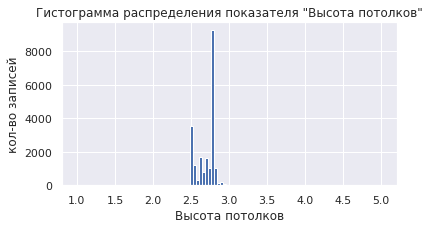

In [28]:
(
    data['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist', 
              bins=100, range=(1,5), grid=True, title='Гистограмма распределения показателя "Высота потолков"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Высота потолков')
);

Гистограмма распределения нормально распределена, поскольку мы ранее удаляли все значения выше 3 м. 

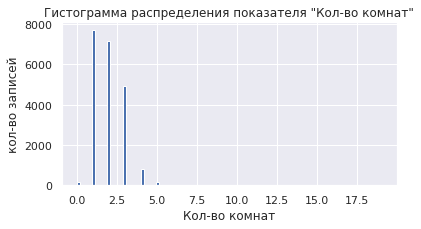

In [29]:
(
    data['rooms']
        .sort_values()
        .plot(y='rooms', kind='hist', 
              bins=100, range=(0,19), grid=True, title='Гистограмма распределения показателя "Кол-во комнат"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Кол-во комнат')
);

Гистограмма нормально распределена, аномалий нет

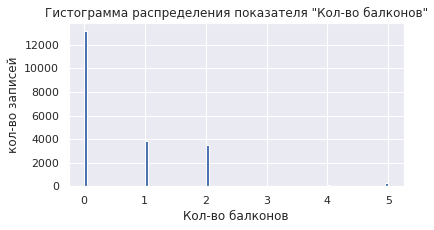

In [30]:
(
    data['balcony']
        .sort_values()
        .plot(y='balcony', kind='hist', 
              bins=100, range=(0,5), grid=True, title='Гистограмма распределения показателя "Кол-во балконов"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Кол-во балконов')
);

Гистограмма нормально распределена, аномалий нет

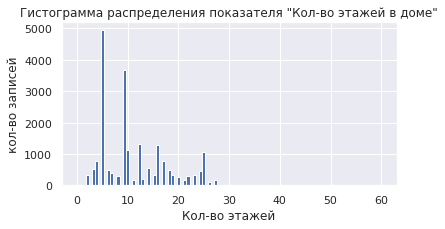

In [31]:
(
    data['floors_total']
        .sort_values()
        .plot(y='floors_total', kind='hist', 
              bins=100, range=(0,60), grid=True, title='Гистограмма распределения показателя "Кол-во этажей в доме"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Кол-во этажей')
);

На графике видно что после 30 практически нет значений, можно ограничить выборку этажностью дома до 30

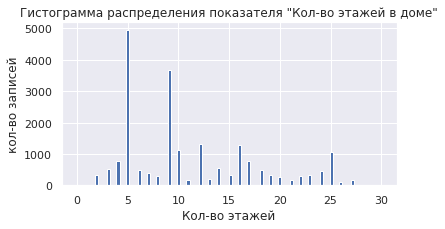

In [32]:
data=data[data['floors_total']<30]

(
    data['floors_total']
        .sort_values()
        .plot(y='floors_total', kind='hist', 
              bins=100, range=(0,30), grid=True, title='Гистограмма распределения показателя "Кол-во этажей в доме"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Кол-во этажей')
);

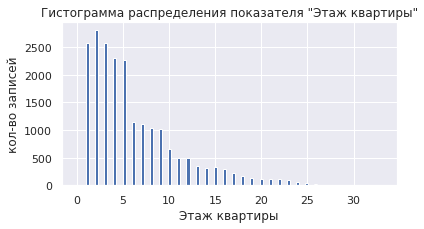

In [33]:
(
    data['floor']
        .sort_values()
        .plot(y='floor', kind='hist', 
              bins=100, range=(0,33), grid=True, title='Гистограмма распределения показателя "Этаж квартиры"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Этаж квартиры')
);

Гистограмма нормального распределения, аномалий нет

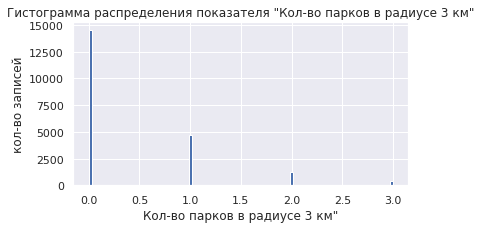

In [34]:
(
    data['parks_around3000']
        .sort_values()
        .plot(y='parks_around3000', kind='hist', 
              bins=100, grid=True, title='Гистограмма распределения показателя "Кол-во парков в радиусе 3 км"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Кол-во парков в радиусе 3 км"')
);

Гистограмма распределения Пуассона, аномалий нет

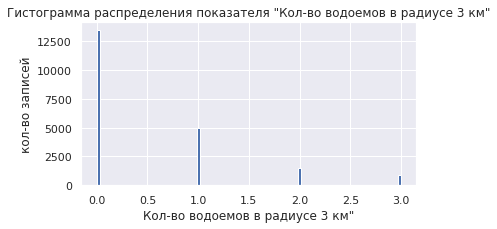

In [35]:
(
    data['ponds_around3000']
        .sort_values()
        .plot(y='ponds_around3000', kind='hist', 
              bins=100, grid=True, title='Гистограмма распределения показателя "Кол-во водоемов в радиусе 3 км"', figsize=(6,3))        
        .set( ylabel = 'кол-во записей', xlabel = 'Кол-во водоемов в радиусе 3 км"')
);

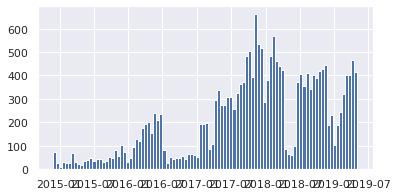

In [36]:
(
    data['first_day_exposition']
        .hist(bins=100, grid=True, figsize=(6,3))
);

Данные нельзя описать каким-то распределением

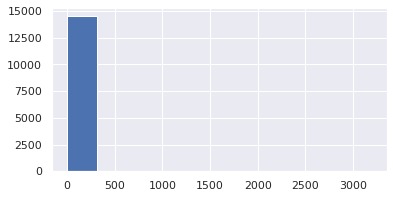

In [37]:
(
    data['parks_nearest']
        .hist(bins=10,grid=True, figsize=(6,3))
);

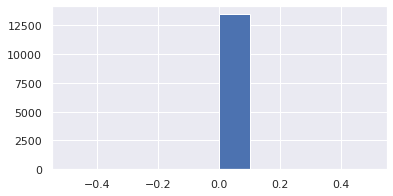

In [38]:
(
    data['ponds_nearest']
        .hist(bins=10, grid=True, figsize=(6,3))
);

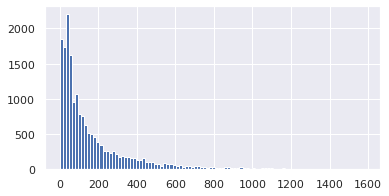

In [39]:
(
    data['days_exposition']
        .hist(bins=100, grid=True, figsize=(6,3))
);

Данные можно описать распределением Пуассона

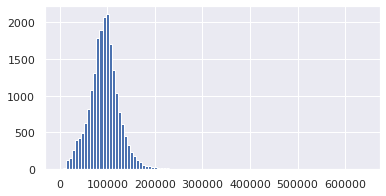

In [40]:
(
    data['price_per_square_meter']
        .hist(bins=100, grid=True, figsize=(6,3))
);

Нормальное распределение

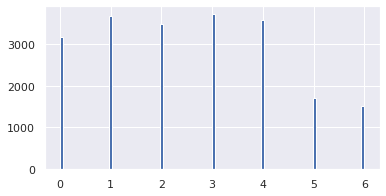

In [41]:
(
    data['weekday_exposition']
        .hist(bins=100, grid=True, figsize=(6,3))
);

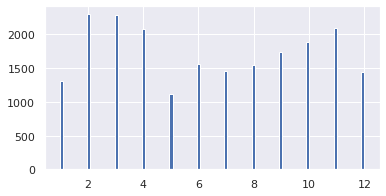

In [42]:
(
    data['month_exposition']
        .hist(bins=100, grid=True, figsize=(6,3))
);

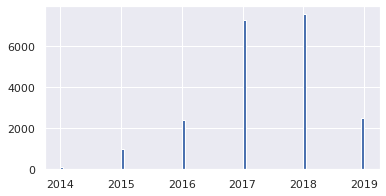

In [43]:
(
    data['year_exposition']
        .hist(bins=100, grid=True, figsize=(6,3))
);

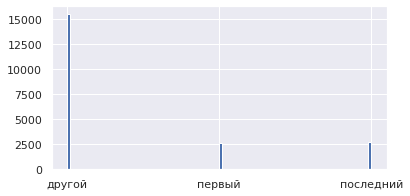

In [44]:
(
    data['floor_category']
        .hist(bins=100, grid=True, figsize=(6,3))
);

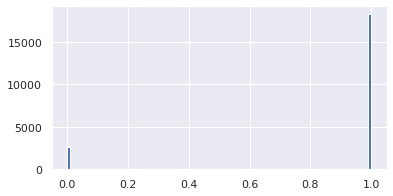

In [45]:
(
    data['floor_category_digit']
        .hist(bins=100, grid=True, figsize=(6,3))
);

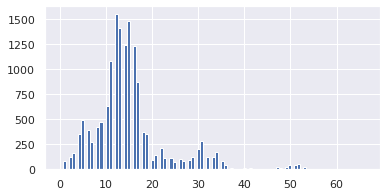

In [46]:
(
    data['cityCenters_nearest_km']
        .hist(bins=100, grid=True, figsize=(6,3))
);

Гистограмма распределения Пуассона, аномалий нет

In [47]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,cityCenters_nearest_km
count,20822.000000,20822.000000,20822.000000,20822.000000,20822.00000,20822.000000,20822.000000,20822.000000,20688.000000,20822.000000,...,14541.000000,20822.000000,13452.0,18265.000000,20822.000000,20822.000000,20822.000000,20822.000000,20822.000000,15505.000000
mean,9.764192,5.229850,54.747160,1.953703,2.68519,11.132840,31.243650,6.081212,8.989403,0.616463,...,0.649474,0.514936,0.0,172.050643,93831.106282,2.581596,6.411392,2017.377870,0.876477,15.156143
std,5.618237,3.522564,22.703513,0.940152,0.11570,6.605731,14.922111,4.969557,5.181147,0.962659,...,45.221572,0.812847,0.0,210.331111,33752.303544,1.794372,3.490029,1.024856,0.329045,8.333814
min,0.000000,0.012190,12.000000,0.000000,1.00000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.000000,111.000000,0.000000,1.000000,2014.000000,0.000000,0.000000
25%,6.000000,3.300000,39.000000,1.000000,2.60000,5.000000,18.400000,2.000000,6.200000,0.000000,...,0.000000,0.000000,0.0,44.000000,74667.000000,1.000000,3.000000,2017.000000,1.000000,11.000000
50%,9.000000,4.399000,49.100000,2.000000,2.77000,9.000000,29.100000,5.000000,8.500000,0.000000,...,0.000000,0.000000,0.0,91.000000,93023.000000,3.000000,6.000000,2017.000000,1.000000,14.000000
75%,14.000000,6.000000,64.100000,3.000000,2.77000,16.000000,39.707500,8.000000,11.000000,1.000000,...,0.000000,1.000000,0.0,217.000000,110596.250000,4.000000,10.000000,2018.000000,1.000000,17.000000
max,50.000000,39.773280,199.200000,8.000000,2.99000,29.000000,159.600000,27.000000,65.000000,5.000000,...,3190.000000,3.000000,0.0,1580.000000,640422.000000,6.000000,12.000000,2019.000000,1.000000,66.000000


После устранения аномалий кол-во значений в выборке снизилось до 20822 с 23699, т.е. на 12%. Это допустимое значение.

count    18265.000000
mean       172.050643
std        210.331111
min          1.000000
25%         44.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64


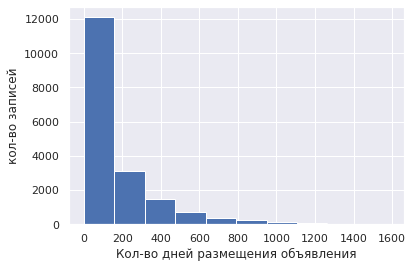

In [48]:
#Изучаем как быстро продавались квартиры
data['days_exposition'].hist().set( ylabel = 'кол-во записей', xlabel = 'Кол-во дней размещения объявления')
print(data['days_exposition'].describe())

- Продажа обычно занимает 91 дней (50%-квартиль)
- Продажи более 217 дней считаются долгими (75%-квартиль)
- Продажи менее 44 дней - быстрыми (25%-квартиль)

[Text(0, 0.5, 'кол-во записей'),
 Text(0.5, 0, 'Кол-во дней размещения объявления')]

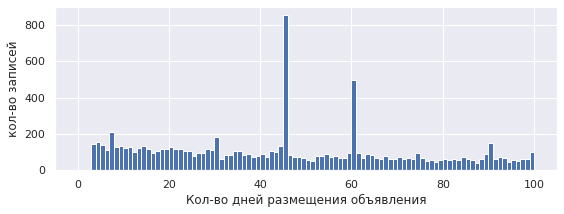

In [49]:
data['days_exposition'].hist(bins=100,range=(0,100),figsize = (9,3)).set( ylabel = 'кол-во записей', xlabel = 'Кол-во дней размещения объявления')

Прослеживается явная зависимость стоимости стоимости квартиры от ее общей площади. Корреляция между показателями составляет: 0.763
Прослеживается явная зависимость стоимости стоимости квартиры от ее жилой площади. Корреляция между показателями составляет: 0.651
Прослеживается некоторая зависимость стоимости стоимости квартиры от площади кухни. Корреляция между показателями составляет: 0.474 
Прослеживается некоторая зависимость стоимости стоимости квартиры от кол-ва комнат. Корреляция между показателями составляет: 0.462


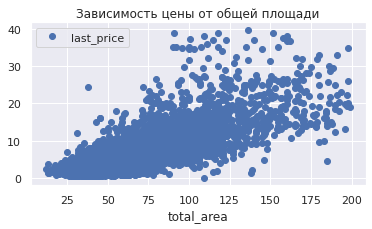

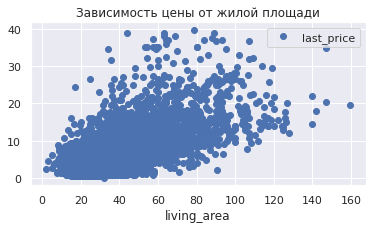

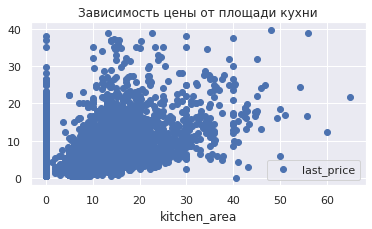

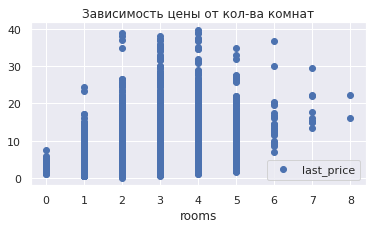

In [50]:
data = data[data['last_price']<500] #Удаляем выбросы по ценам
data = data[data['total_area']<800] #Удаляем выбросы по площади
data.plot(title = 'Зависимость цены от общей площади', x='total_area', y='last_price', style = 'o', grid=True, figsize=(6,3))
corr_price_area = data['last_price'].corr(data['total_area']).round(3)
print('Прослеживается явная зависимость стоимости стоимости квартиры от ее общей площади. Корреляция между показателями составляет:',corr_price_area)

data.plot(title = 'Зависимость цены от жилой площади', x='living_area', y='last_price', style = 'o', grid=True, figsize = (6,3))
corr_price_area_live = data['last_price'].corr(data['living_area']).round(3)

print('Прослеживается явная зависимость стоимости стоимости квартиры от ее жилой площади. Корреляция между показателями составляет:',corr_price_area_live)

data.plot(title = 'Зависимость цены от площади кухни', x='kitchen_area', y='last_price', style = 'o', grid=True, figsize = (6,3))
corr_price_area_kitch = data['last_price'].corr(data['kitchen_area']).round(3)

print('Прослеживается некоторая зависимость стоимости стоимости квартиры от площади кухни. Корреляция между показателями составляет:',corr_price_area_kitch, '')

data.plot(title = 'Зависимость цены от кол-ва комнат', x='rooms', y='last_price', style = 'o', grid=True, figsize = (6,3))
corr_price_area_rooms = data['last_price'].corr(data['rooms']).round(3)

print('Прослеживается некоторая зависимость стоимости стоимости квартиры от кол-ва комнат. Корреляция между показателями составляет:',corr_price_area_rooms)


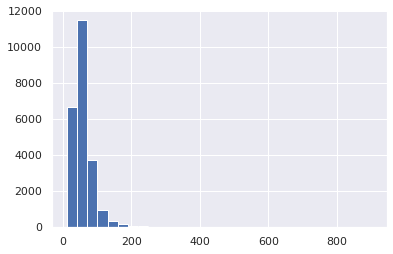

In [51]:
#код ревьюера
data2 = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
(data2['total_area']).hist(bins=30);

,last_price
,mean
floor_category,
другой,1.000000
первый,0.760738
последний,0.872879


Квартиры на первом этаже, как правило, дешевле на 24%
Квартиры на последнем этаже, как правило, дешевле на 13%


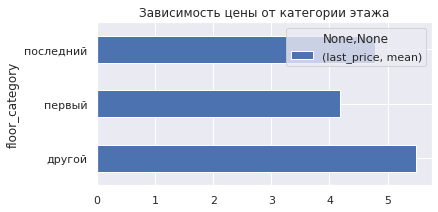

In [52]:
#Оценим влияние категориальных значений на цену объекта
data.groupby('floor_category').agg({'last_price': ['mean']}).plot(kind='barh',figsize=(6,3),title='Зависимость цены от категории этажа');

display(data.groupby('floor_category').agg({'last_price': ['mean']})/5.484665)
print('Квартиры на первом этаже, как правило, дешевле на 24%')
print('Квартиры на последнем этаже, как правило, дешевле на 13%')

В четверг обычно размещались объявления о продаже дорогих квартир, в субботу и воскресение - самых дешевых


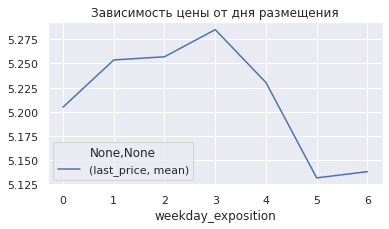

In [53]:
data.groupby('weekday_exposition').agg({'last_price': ['mean']}).plot(title = 'Зависимость цены от дня размещения',figsize=(6,3))
print('В четверг обычно размещались объявления о продаже дорогих квартир, в субботу и воскресение - самых дешевых')

В ноябре и сентябре размещались объявления о продаже дорогих квартир, в июне - самых дешевых


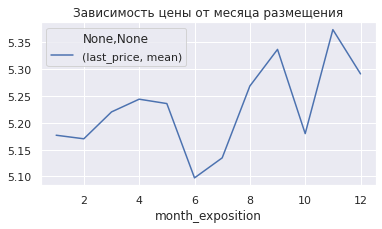

In [54]:
data.groupby('month_exposition').agg({'last_price':['mean']}).plot(title = 'Зависимость цены от месяца размещения', figsize=(6,3))
print('В ноябре и сентябре размещались объявления о продаже дорогих квартир, в июне - самых дешевых')

Цены на квартиры снижальсь в течение 4 лет с 2014 по 2018 гг. В 2019 наблюдался рост. Однако, уровень цен не достигнул уровня 2015 г.


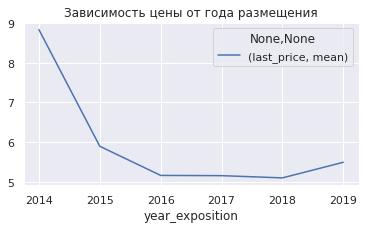

In [55]:
data.groupby('year_exposition').agg({'last_price': ['mean']}).plot(title = 'Зависимость цены от года размещения',figsize=(6,3))
print('Цены на квартиры снижальсь в течение 4 лет с 2014 по 2018 гг. В 2019 наблюдался рост. Однако, уровень цен не достигнул уровня 2015 г.')

Самая дорогая стоимость квадратного метра жилья в г. Санкт-Петербург (120 тыс руб кв м), затем следует Пушкин (110 тыс руб кв м). Самое дешевое жилье в г. Выборг - менее 60 тыс руб за кв м


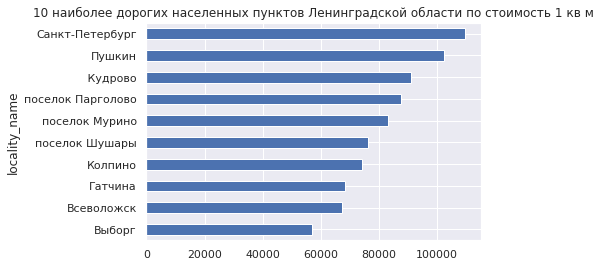

In [56]:
top10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top10.pop('total_area_count')
top10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top10 = top10.iloc[:10]
top10['price_per_square_meter'] = top10['last_price_sum']*1000000/top10['total_area_sum']
top10.sort_values(by=['price_per_square_meter'],ascending=True, inplace=True)
top10['price_per_square_meter'].plot(title = '10 наиболее дорогих населенных пунктов Ленинградской области по стоимость 1 кв м',kind='barh')

print('Самая дорогая стоимость квадратного метра жилья в г. Санкт-Петербург (120 тыс руб кв м), затем следует Пушкин (110 тыс руб кв м). Самое дешевое жилье в г. Выборг - менее 60 тыс руб за кв м')

Есть явная зависимость: чем ближе к центру города, тем выше цена объекта


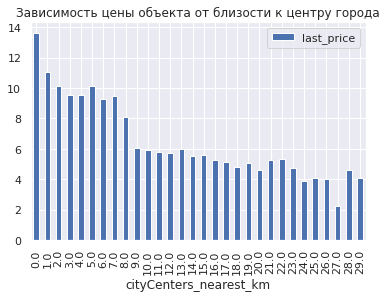

In [57]:
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean').plot(title = 'Зависимость цены объекта от близости к центру города', kind='bar')
print('Есть явная зависимость: чем ближе к центру города, тем выше цена объекта')

In [58]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category_digit,cityCenters_nearest_km
count,20822.000000,20822.000000,20822.000000,20822.000000,20822.00000,20822.000000,20822.000000,20822.000000,20688.000000,20822.000000,...,14541.000000,20822.000000,13452.0,18265.000000,20822.000000,20822.000000,20822.000000,20822.000000,20822.000000,15505.000000
mean,9.764192,5.229850,54.747160,1.953703,2.68519,11.132840,31.243650,6.081212,8.989403,0.616463,...,0.649474,0.514936,0.0,172.050643,93831.106282,2.581596,6.411392,2017.377870,0.876477,15.156143
std,5.618237,3.522564,22.703513,0.940152,0.11570,6.605731,14.922111,4.969557,5.181147,0.962659,...,45.221572,0.812847,0.0,210.331111,33752.303544,1.794372,3.490029,1.024856,0.329045,8.333814
min,0.000000,0.012190,12.000000,0.000000,1.00000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.000000,111.000000,0.000000,1.000000,2014.000000,0.000000,0.000000
25%,6.000000,3.300000,39.000000,1.000000,2.60000,5.000000,18.400000,2.000000,6.200000,0.000000,...,0.000000,0.000000,0.0,44.000000,74667.000000,1.000000,3.000000,2017.000000,1.000000,11.000000
50%,9.000000,4.399000,49.100000,2.000000,2.77000,9.000000,29.100000,5.000000,8.500000,0.000000,...,0.000000,0.000000,0.0,91.000000,93023.000000,3.000000,6.000000,2017.000000,1.000000,14.000000
75%,14.000000,6.000000,64.100000,3.000000,2.77000,16.000000,39.707500,8.000000,11.000000,1.000000,...,0.000000,1.000000,0.0,217.000000,110596.250000,4.000000,10.000000,2018.000000,1.000000,17.000000
max,50.000000,39.773280,199.200000,8.000000,2.99000,29.000000,159.600000,27.000000,65.000000,5.000000,...,3190.000000,3.000000,0.0,1580.000000,640422.000000,6.000000,12.000000,2019.000000,1.000000,66.000000


### Общий вывод

**Параметры объектов**

В объявлении:
- 9 изображений
- цена объекта - 4,4 млн руб
- общая площадь - 49 кв м 
- жилая площадь - 29 кв м
- площадь кухни - 8,5 кв м
- кол-во комнат - 2
- высота потолка - 2,77 м
- расстояние до цента 14 км

**Как быстро продавались квартиы**

- Продажа обычно занимает 91 дней (50%-квартиль)
- Продажи более 217 дней считаются долгими (75%-квартиль)
- Продажи менее 44 дней - быстрыми (25%-квартиль)

***Общий вывод***
- Наиболее значимым фактором для цены квартиры является ее общая площадь, затем - жилая площадь, и только затем площадь кухни. Зависимость показателей положительная. Чем выше площадь, тем выше цена.
- Количество комнат также влияет на цену объекта, это скорее всего связано, с увеличением площади при увеличении кол-ва комнат. 
- Квартиры на первом этаже, как правило, дешевле (на 24%), последний этаж (на 13%)
- В четверг обычно размещались объявления о продаже дорогих квартир, в субботу и воскресение - самых дешевых
- В ноябре и сентябре размещались объявления о продаже дорогих квартир, в июне - самых дешевых
- Цены на квартиры снижальсь в течение 4 лет с 2014 по 2018 гг. В 2019 наблюдался рост. Однако, уровень цен не достигнул уровня 2015 г.
- Самая дорогая стоимость квадратного метра жилья в г. Санкт-Петербург (120 тыс руб кв м), затем следует Пушкин (110 тыс руб кв м). 
- Самое дешевое жилье в г. Выборг - менее 60 тыс руб за кв м
- Есть явная зависимость: чем ближе к центру города, тем выше цена объекта.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод